In [0]:
%pip install pydicom pillow

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


image_preview,patient_id,patient_sex,patient_age,series_description,body_part,mpr,study_description,has_contrast,is_valid
,3,M,27,T2_TSE_SAG_384,LSPINE,SAG,L-SPINE,False,True
,3,M,27,T2_TSE_SAG_384,LSPINE,SAG,L-SPINE,False,True
,3,M,27,T2_TSE_TRA_384,LSPINE,SAG,L-SPINE,False,True
,3,M,27,T2_TSE_SAG_384,LSPINE,SAG,L-SPINE,False,True
,3,M,27,T2_TSE_TRA_384,LSPINE,SAG,L-SPINE,False,True
,3,M,27,T2_TSE_SAG_384,LSPINE,SAG,L-SPINE,False,True
,3,M,27,T2_TSE_SAG_384,LSPINE,SAG,L-SPINE,False,True
,3,M,27,T2_TSE_SAG_384,LSPINE,SAG,L-SPINE,False,True
,3,M,27,T2_TSE_SAG_384,LSPINE,SAG,L-SPINE,False,True
,3,M,27,T2_TSE_SAG_384,LSPINE,SAG,L-SPINE,False,True

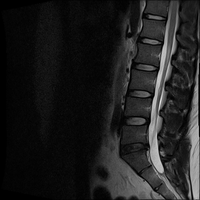
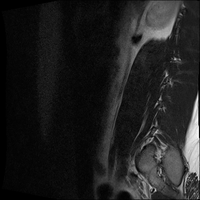
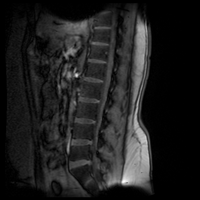
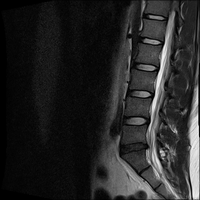
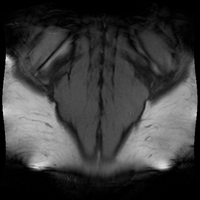
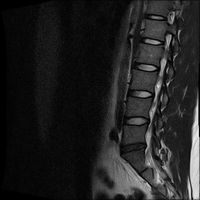
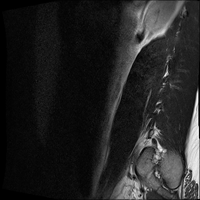
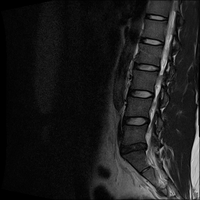
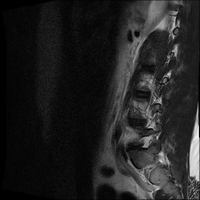
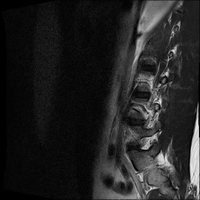

In [0]:
# List các cột filter
columns = [
    "patient_id", "patient_notes", "patient_sex", "patient_age",
    "patient_weight", "patient_height", "patient_position",
    "study_date", "study_description", "series_description",
    "modality", "body_part", "mpr", "has_contrast",
    "is_valid", "error_type", "sop_instance_uid", "path"
]

# Tạo widgets động
for col in columns:
    if col in ["has_contrast", "is_valid"]:
        dbutils.widgets.dropdown(col, "All", ["All","true","false"])
    else:
        dbutils.widgets.text(col, "")

# Thêm widget cho số dòng hiển thị tối đa
dbutils.widgets.dropdown("max_rows", "30", ["10", "20", "30", "50", "100", "200"])

# Lấy giá trị widget
filters = {}
for col in columns:
    filters[col] = dbutils.widgets.get(col)

# Lấy số dòng tối đa
max_rows = int(dbutils.widgets.get("max_rows"))

df = spark.table("dbms.gold.image_info")

from pyspark.sql.functions import col, lower, udf
from pyspark.sql.types import StringType
import base64
import pydicom
import numpy as np
from PIL import Image
import io

# Hàm tạo HTML img tag từ DICOM path - Tối ưu hóa kích thước
def create_dicom_image_html(path):
    if path is None or path == "":
        return ""
    try:
        # Đọc DICOM file
        dicom = pydicom.dcmread(path)
        
        # Lấy pixel array
        image_array = dicom.pixel_array
        
        # Normalize về 0-255
        image_array = ((image_array - image_array.min()) / 
                       (image_array.max() - image_array.min()) * 255).astype(np.uint8)
        
        # Convert sang PIL Image
        image = Image.fromarray(image_array)
        
        # Resize ảnh để giảm dung lượng (thumbnail)
        image.thumbnail((200, 200), Image.Resampling.LANCZOS)
        
        # Convert sang base64
        buffered = io.BytesIO()
        image.save(buffered, format="PNG", optimize=True)
        encoded = base64.b64encode(buffered.getvalue()).decode()
        
        # Trả về HTML img tag với kích thước cố định
        return f'<img src="data:image/png;base64,{encoded}" style="width: 120px; height: 120px; object-fit: contain; display: block; margin: auto;"/>'
    except Exception as e:
        return f'<span style="color: red; font-size: 10px;">Error loading image</span>'

# Đăng ký UDF
image_html_udf = udf(create_dicom_image_html, StringType())

# Apply filters
for col_name, value in filters.items():
    if value != "" and value != "All":
        if col_name in ["has_contrast", "is_valid"]:
            bool_value = True if value.lower() == "true" else False
            df = df.filter(col(col_name) == bool_value)
        elif col_name in ["patient_age", "patient_weight", "patient_height", "patient_id"]:
            df = df.filter(col(col_name) == float(value))
        elif col_name in ["mpr"]:
            df = df.filter(col(col_name) == value)
        else:
            df = df.filter(lower(col(col_name)).like(f"%{value.lower()}%"))

# Đếm tổng số dòng sau khi filter
total_rows = df.count()

# Thêm cột image_preview
df_with_image = df.withColumn("image_preview", image_html_udf(col("path")))

# Chọn các cột quan trọng để hiển thị (tránh quá nhiều cột)
display_columns = ["image_preview", "patient_id", "patient_sex", "patient_age", "series_description" ,
                   "body_part", "mpr", "study_description", "has_contrast", "is_valid"]

df_display = df_with_image.select(*display_columns)

# Chuyển sang Pandas và display với HTML
df_pandas = df_display.limit(max_rows).toPandas()

# Tạo HTML table với styling đẹp hơn
html = f"""
<style>
    * {{ box-sizing: border-box; }}
    .info-banner {{
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 15px;
        border-radius: 8px;
        margin-bottom: 15px;
        font-family: Arial, sans-serif;
        box-shadow: 0 2px 6px rgba(0,0,0,0.15);
    }}
    .info-banner h3 {{
        margin: 0 0 8px 0;
        font-size: 18px;
    }}
    .info-banner p {{
        margin: 5px 0;
        font-size: 14px;
        opacity: 0.95;
    }}
    .table-container {{ 
        width: 100%; 
        overflow-x: auto; 
        margin: 20px 0;
    }}
    table {{ 
        border-collapse: collapse; 
        width: 100%; 
        font-size: 13px;
        font-family: Arial, sans-serif;
        background: white;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }}
    th {{ 
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 12px 8px;
        text-align: left;
        font-weight: 600;
        position: sticky;
        top: 0;
        z-index: 10;
        white-space: nowrap;
    }}
    td {{ 
        border: 1px solid #e0e0e0;
        padding: 10px 8px;
        vertical-align: middle;
    }}
    tr:nth-child(even) {{ 
        background-color: #f8f9fa;
    }}
    tr:hover {{ 
        background-color: #e3f2fd;
        transition: background-color 0.3s;
    }}
    img {{ 
        border: 2px solid #ddd;
        border-radius: 8px;
        padding: 4px;
        background: white;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
    }}
    .error {{ 
        color: #d32f2f;
        font-size: 11px;
        font-style: italic;
    }}
    td:first-child, th:first-child {{
        width: 140px;
        text-align: center;
    }}
</style>
<div class="info-banner">
    <h3>📊 Kết quả hiển thị</h3>
    <p><strong>Tổng số dòng sau khi filter:</strong> {total_rows:,}</p>
    <p><strong>Số dòng hiển thị:</strong> {min(max_rows, total_rows):,} / {total_rows:,}</p>
    <p><strong>Số dòng được chọn:</strong> {max_rows}</p>
</div>
<div class="table-container">
"""
html += df_pandas.to_html(escape=False, index=False, classes="data-table")
html += "</div>"

displayHTML(html)